In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.models import Sequential, Model

from keras.layers import Activation, Flatten, Dense,BatchNormalization, Dropout
from keras.applications.inception_resnet_v2  import InceptionResNetV2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from matplotlib.pyplot import imshow
from keras.models import load_model
from keras.applications.vgg16 import VGG16
from keras.applications  import InceptionV3
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split
import cv2
import shutil
import glob
import os
from PIL import Image
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications import MobileNetV3Small
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19

from keras.applications import InceptionResNetV2


In [2]:
#Train
train_glioma = 'C:/Users/Admin/Downloads/thesis/dataset/Training/glioma'
train_menignioma = 'C:/Users/Admin/Downloads/thesis/dataset/Training/meningioma'
train_pituitary = 'C:/Users/Admin/Downloads/thesis/dataset/Training/pituitary'
train_no = 'C:/Users/Admin/Downloads/thesis/dataset/Training/notumor'
train_dir = 'C:/Users/Admin/Downloads/thesis/dataset/Training/'

#Test
test_glioma = 'C:/Users/Admin/Downloads/thesis/dataset/valid data/glioma_tumor'
test_menignioma = 'C:/Users/Admin/Downloads/thesis/dataset/valid data/meningioma_tumor'
test_pituitary = 'C:/Users/Admin/Downloads/thesis/dataset/valid data/pituitary_tumor'
test_no = 'C:/Users/Admin/Downloads/thesis/dataset/valid data/no_tumor'
test_dir = 'C:/Users/Admin/Downloads/thesis/dataset/valid data/'


In [3]:
#for training dataset
list_brain_image=[train_glioma, train_menignioma, train_no, train_pituitary]
classes=['glioma', 'menignioma','No_tumor','pituitary']
images_location=[]
labels=[]


for i,j in zip(list_brain_image, classes):
    list_of_file=os.listdir(i)
    for f in list_of_file:
        image_location=os.path.join (i,f)
        images_location.append(image_location)
        labels.append(j)



print ('Number of image train: ', len(images_location), '   Number of image train has label: ', len(labels))


#for test dataset
list_brain_image_test=[ test_glioma, test_menignioma, test_no, test_pituitary]
classes_test=['glioma', 'menignioma','No_tumor','pituitary']
images_location_test=[]
labels_test=[]


for i,j in zip(list_brain_image_test, classes_test):
    list_of_file_test=os.listdir(i)
    for f in list_of_file_test:
        image_location_test=os.path.join (i,f)
        images_location_test.append(image_location_test)
        labels_test.append(j)



print ('Number of image test: ', len(images_location_test), '   Number of image test has label: ', len(labels_test))

Number of image train:  7023    Number of image train has label:  7023
Number of image test:  3160    Number of image test has label:  3160


In [4]:
#for training data
Location =pd.Series(images_location, name='location')
Label=pd.Series(labels, name='labels')
#connect the path of brain image and their label 
connect_image_label=pd.concat([Location,Label], axis=1)
connect_image_label = pd.DataFrame(connect_image_label, columns=['location', 'labels'])
connect_image_label.head()

#for test data
Location_test =pd.Series(images_location_test, name='location')
Label_test=pd.Series(labels_test, name='labels')
connect_image_label_test=pd.concat([Location_test,Label_test], axis=1)
connect_image_label_test = pd.DataFrame(connect_image_label_test, columns=['location', 'labels'])
connect_image_label_test.head()

,location,labels
0,C:/Users/Admin/Downloads/thesis/dataset/valid ...,glioma
1,C:/Users/Admin/Downloads/thesis/dataset/valid ...,glioma
2,C:/Users/Admin/Downloads/thesis/dataset/valid ...,glioma
3,C:/Users/Admin/Downloads/thesis/dataset/valid ...,glioma
4,C:/Users/Admin/Downloads/thesis/dataset/valid ...,glioma


In [5]:
#split the data to 3 part : train dataset, test dataset, validation data
train,valid = train_test_split(connect_image_label, train_size=0.8, random_state=3)

print(f"train set: {train.shape}")
print(f"validation set: {valid.shape}")

train set: (5618, 2)
validation set: (1405, 2)


In [6]:
#rescale image from rgb (0-255) to (0,1)
train_image_datagen = ImageDataGenerator(rescale = 1./255.)
test_image_datagen = ImageDataGenerator(rescale = 1.0/255.)
valid_image_datagen = ImageDataGenerator(rescale = 1.0/255.)



train_datagen = train_image_datagen.flow_from_dataframe(train,
                                              x_col = 'location', y_col ='labels',
                                              target_size = (299,299),
                                              class_mode = 'categorical', shuffle = True)


validation_datagen = valid_image_datagen.flow_from_dataframe(valid,
                                            target_size=(299,299), x_col = 'location', y_col ='labels',
                                            class_mode='categorical',
                                            batch_size= 20, shuffle=True)
                                            

test_datagen = test_image_datagen.flow_from_dataframe(connect_image_label_test,
                                            target_size = (299,299), x_col = 'location', y_col ='labels',
                                             class_mode = 'categorical',
                                            batch_size = 15, shuffle = False)

Found 5618 validated image filenames belonging to 4 classes.
Found 1405 validated image filenames belonging to 4 classes.
Found 3160 validated image filenames belonging to 4 classes.


In [7]:
from keras.layers import Input, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Model
from keras.optimizers import RMSprop
from keras.applications import MobileNetV3Large
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the input shape
input_shape = (299, 299, 3)

# Create one input for both x1 and x2
input_layer = Input(shape=input_shape)

# Create base models
base_model_1 = MobileNetV3Large(weights='imagenet', include_top=False, input_tensor=input_layer)

# Freeze the layers of the base models except for last few layers to fine-tune them 
# Fine-tune some layers of the base model
for layer in base_model_1.layers:
    layer.trainable = False


# Add your own custom layers on top of the base models 
x1 = base_model_1.output 
x1 = Flatten()(x1) 
x1 = Dense(256, activation='relu')(x1) 
x1 = BatchNormalization()(x1) 
x1 = Dropout(0.5)(x1) 
output = Dense(4, activation='softmax')(x1) 

mobilenetv3 = Model(inputs=input_layer, outputs=output)

# Compile model with a smaller learning rate and momentum to ensure convergence while fine-tuning.
mobilenetv3.compile(optimizer=RMSprop(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
mobilenetv3.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 299, 299, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 150, 150, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 150, 150, 16)         64        ['Conv[0][0]']                
 lization)                                                                                    

In [8]:
mobilenetv3.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.001),  metrics= ['categorical_accuracy'])

history = mobilenetv3.fit(train_datagen, validation_data = validation_datagen, epochs = 30)

Epoch 1/30



176/176 [==============================] - 62s 336ms/step - loss: 0.8643 - categorical_accuracy: 0.6597 - val_loss: 0.9372 - val_categorical_accuracy: 0.6228
Epoch 2/30
176/176 [==============================] - 57s 322ms/step - loss: 0.6721 - categorical_accuracy: 0.7417 - val_loss: 0.7726 - val_categorical_accuracy: 0.7053
Epoch 3/30
176/176 [==============================] - 60s 340ms/step - loss: 0.5961 - categorical_accuracy: 0.7711 - val_loss: 0.8241 - val_categorical_accuracy: 0.6947
Epoch 4/30
176/176 [==============================] - 65s 369ms/step - loss: 0.5561 - categorical_accuracy: 0.7873 - val_loss: 0.6406 - val_categorical_accuracy: 0.7345
Epoch 5/30
176/176 [==============================] - 66s 374ms/step - loss: 0.5259 - categorical_accuracy: 0.8072 - val_loss: 0.4685 - val_categorical_accuracy: 0.8157
Epoch 6/30
176/176 [==============================] - 65s 369ms/step - loss: 0.5000 - categorical_accuracy: 0.8060 - val_loss: 0.6301 - val_categorical_accuracy: 0.75

In [13]:
model_mobilenetV3_final = mobilenetv3  # Get model (Sequential, Functional Model, or Model subclass)
model_mobilenetV3_final.save('mobilenetv3_23_1.keras')  # The file needs to end with the .keras extension

In [14]:
model_mobilenetV3_final = keras.models.load_model('mobilenetv3_23_1.keras')
# Evaluate the model on the test data`
test_loss, test_accuracy = model_mobilenetV3_final.evaluate(test_datagen)

211/211 [==============================] - 24s 108ms/step - loss: 0.7845 - categorical_accuracy: 0.7870


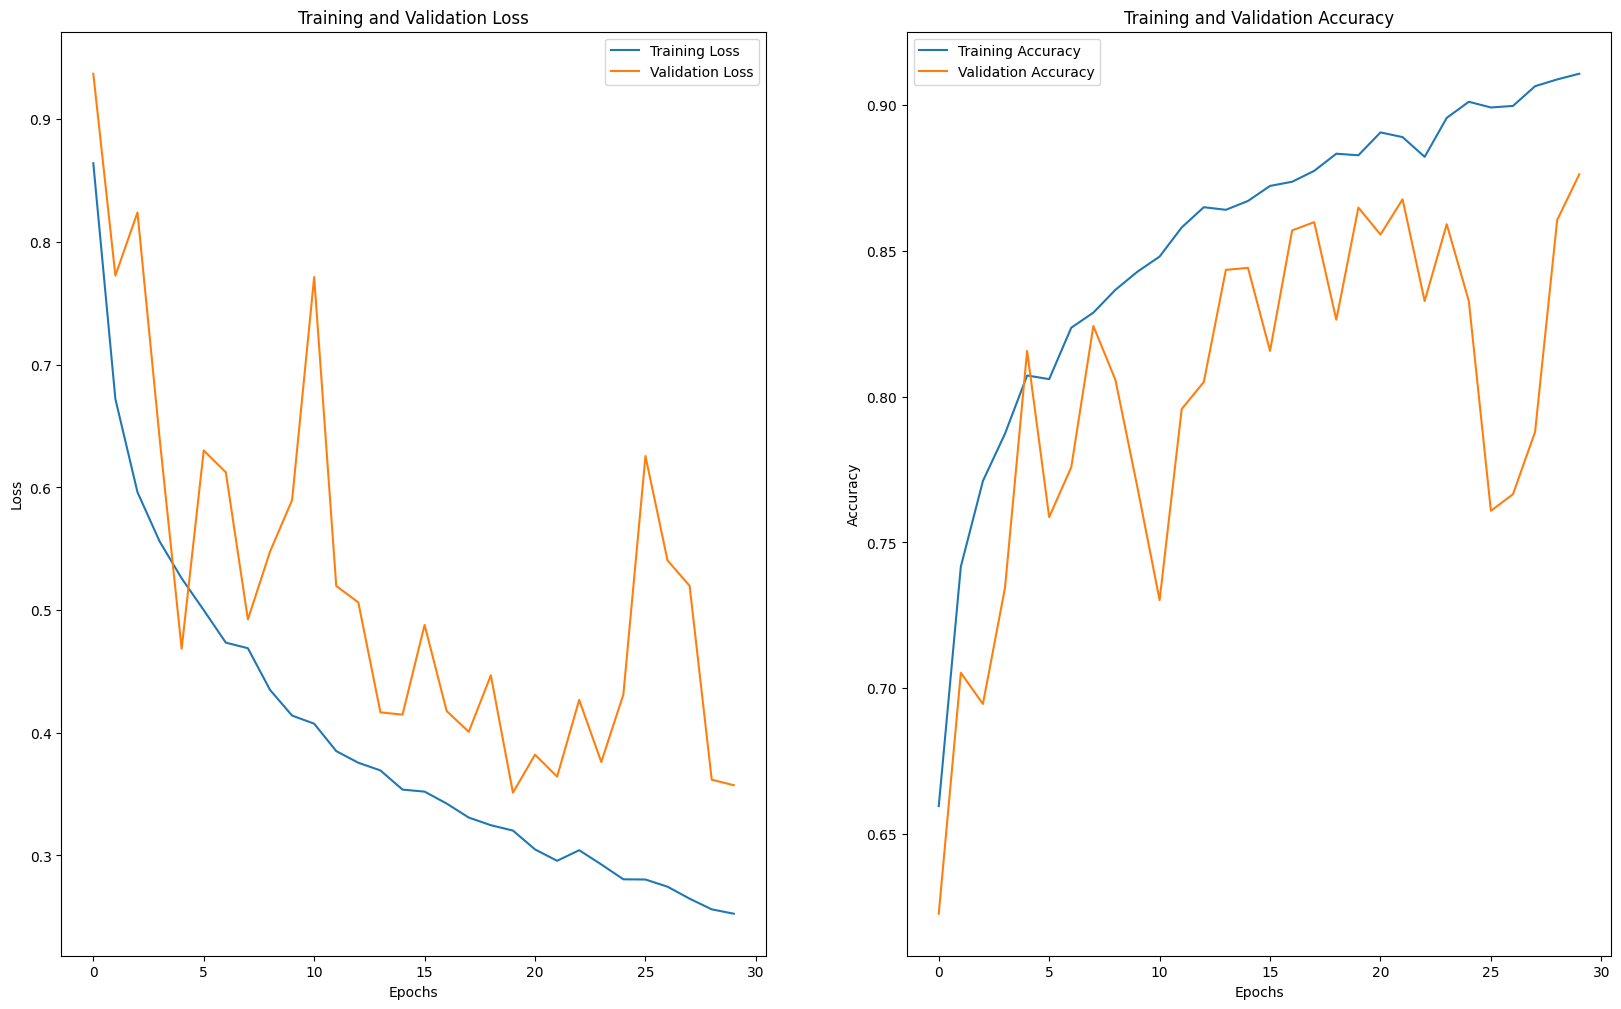

In [17]:
import matplotlib.pyplot as plt
import numpy as np



# Plot loss and accuracy curves
plt.figure(figsize=(20, 12))
# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Plot Training Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
